# Import packages

In [269]:
# Simulator related packages

import numpy as np
import scipy as sp
from numba import jit, njit, prange
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Update rcParams to use Arial globally
rcParams['font.family'] = 'Arial'

from IPython.display import display, clear_output
import random


In [2]:
# Install required packages and download sample data

!pip install botorch
!pip install gpytorch
!pip install spmsimu

!gdown 1lDPXw0V6JoITDDFOHudSaOFSP478Afdm
!gdown 1LGvIhgtq63sosehbtDy0KIoOHf6nPEnV

In [3]:
# AC-BO related packages

import torch

from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize

from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound, LogExpectedImprovement
from gpytorch.distributions import MultivariateNormal
import gpytorch

import warnings
warnings.filterwarnings('ignore')

from jax.lib import xla_bridge

print(xla_bridge.get_backend().platform)

cpu


# Pre-define functions

## Experiment objects to run the simulation

In [4]:
import types

class Experiment(object):
    '''
    Experiment data structure for SPM auto-optimization simulation.
    '''
    def __init__(self):
        super(Experiment, self).__init__()

        # Initialize parameter dict
        self.param = {}

    def update_param(self, key, value):
        '''
        Update the value stored in obj.param

        Input:
            key     - List: keys to be modifies in obj.param
            value   - List: values to be entered in obj.param['key']

        Output:
            N/A

        Usage:
            obj.update_param(key=['DriveAmplitude', 'Setpoint'], value=[0.1, 0.2])
        '''
        if type(key) is not list:
            key = [key]

        if len(key) == 1:
            self.param[key[0]] = value

        else:
            for i, ix in enumerate(key):
                self.param[ix] = value[i]

    def add_func(self, NewFunc):
        '''
        Add a custom function as the method to Experiment object.

        Input:
            NewFunc - Function: Custom function defined by user. This function has aceess
                        to all the attributes and methods of obj
        Output:
            N/A
        Usage:
            def measure(self, operation, key, value):
                self.update_param(key=key, value=value)
                self.execute(operation)
            obj.add_func(measure)
        '''

        method_name = NewFunc.__name__

        # add new function name to the custom action list
        # self.action_list[method_name] = method_name

        # Bind the function as a method of the instance
        bound_method = types.MethodType(NewFunc, self)

        # Set the method to the instance
        setattr(self, method_name, bound_method)


In [5]:
from spmsimu.simulator import *
# from simulator import *


## Grid-search of the rewards

In [6]:
from numba import jit, njit, prange

def reward_grid(h1, h2, ph1, ph2, offset=0):

    # h1, h2 = height
    # ph1, ph2 = phase
    h2 = h2[:, ::-1]
    ph2 = ph2

    diff = np.abs(h1-h2)
    # index3 = np.where((ph1 - offset > 90) & (ph1 - offset < 120))
    # index4 = np.where((ph2 - offset > 90) & (ph2 - offset < 120))

    # phase_above_factor = (len(index3[0]) + len(index4[0])) / len(h1) * 50
    # phase_above_factor = np.e if phase_above_factor <= np.e else phase_above_factor

    height_trace_factor = np.abs(np.sum(diff / (h1-np.min(h1)+1))) * 1e2

    base =  height_trace_factor #* 1 * 1 # / np.log(phase_above_factor) / 1
    # base =  height_trace_factor * np.log(height_factor) * np.log(phase_smooth_factor) / np.log(phase_above_factor) / np.log(other_factor)

    index1 = np.where(ph1 -  offset < 90)
    index2 = np.where(ph2 -  offset < 90)

    ph1_masked1 = np.copy(ph1)
    ph1_masked1[np.where(ph1 - offset > 90)] = 90

    ph2_masked1 = np.copy(ph2)
    ph2_masked1[np.where(ph2 - offset > 90)] = 90
    
    m1 = np.sum(90 + offset-ph1_masked1)
    m2 = np.sum(90 + offset-ph2_masked1)

    phase_below_factor = np.e if m1 * m2 <= np.e else m1 * m2

    return -np.log(np.abs(base * np.log(phase_below_factor)))

def measure_grid(img, kernel, drive, setpoint, i_gain=None, repeat=1, reward=True, trace=False):

    # index = self.param['index']
    # We need to simulate the fwd and bkd scans with the scanning parameters
    i_gain = 1e-2 if i_gain is None else i_gain

    N1 = len(drive)
    N2 = len(setpoint)

    rewards = np.zeros((N1, N2))

    for i in range(N1):
        for j in range(N2):
            z1, ph1, z2, ph2 = scan(image=img, kernel=kernel, drive=drive[i],
                            setpoint=setpoint[j], I=i_gain, phase=True, retrace=True, noise=True)
            rewards[i,j] = reward_grid(z1, z2, ph1, ph2)

    return rewards

# Benchmarking the AC BO algorithm

## Set up the grid-search

In [7]:
# # Here we will use the reward computed for the whole map to generate the grid-data

# exp = Experiment()

# exp.add_func(reward_grid)
# exp.add_func(measure_grid)


In [8]:
droplets = np.load('droplets.npy')
np.shape(droplets)

(4, 256, 256)

Text(0.5, 1.0, 'Image with real tip')

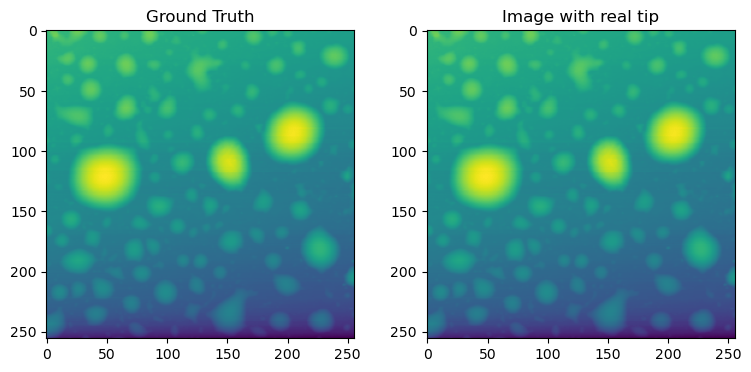

In [9]:
# Generate the checkerboard pattern
# img = generate_checkerboard(nx=256, ny=256, n_box=10)
# img = norm_(at.lineSubtract(droplets[0], 1))
img = norm_(droplets[0])

Lx, Ly = np.shape(img)

kernel_size = 50
wx = 2.5   # x width of the probe
wy = 2.5   # y width of the probe

kernel_1 = generate_tip_kernel(kernel_size, wx, wy, tip_height=1)

z_checkerboard = tip_scan(img, kernel_1)

fig, ax=plt.subplots(1,2,figsize=[9,4])
ax[0].imshow(img)
ax[1].imshow(z_checkerboard)

ax[0].set_title('Ground Truth')
ax[1].set_title('Image with real tip')

Text(0.5, 1.0, 'Image with real tip')

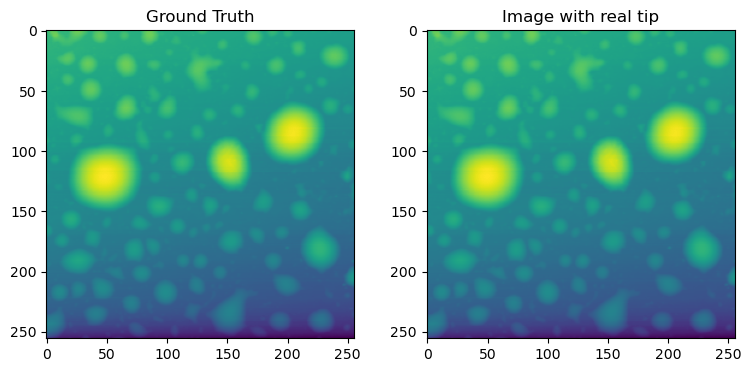

In [10]:
z1, ph1, z2, ph2 = scan(image=img, kernel=kernel_1, drive=0.5,
                                setpoint=0.85, I=1e-2, phase=True, retrace=True, noise=True)

fig, ax=plt.subplots(1,2,figsize=[9,4])
ax[0].imshow(img)
ax[1].imshow(z1)

ax[0].set_title('Ground Truth')
ax[1].set_title('Image with real tip')

Text(0, 0.5, 'Drive Amplitude')

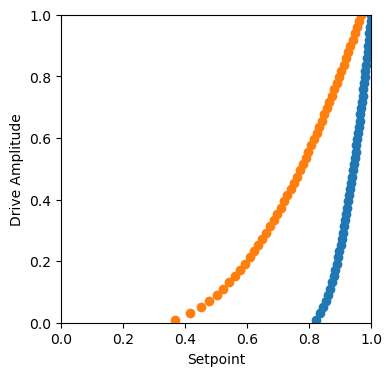

In [258]:
# Here is the phase generation relation

drive = np.linspace(0.01, 1, 50)
setpoint = (np.sqrt(drive))/5+0.8
setpoint2 = (np.sqrt(drive)/1.5 + 0.3)
# plt.plot(drive, (1-np.sqrt(1-drive))/10+0.9)

plt.figure(figsize=[4,4])
plt.scatter(setpoint, drive)
plt.scatter(setpoint2, drive)

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Setpoint')
plt.ylabel('Drive Amplitude')
# plt.

In [278]:
phases = np.zeros([100, 100])
for i in range(100):
    for j in range(100):
        phases[i,j] = generate_phase(x1[i], x2[j])

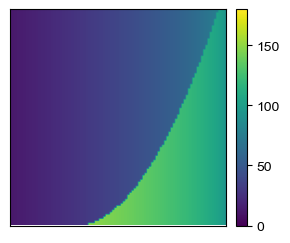

In [384]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=[3,3])

im = plt.imshow(phases.T, extent=[0,1,0,1], origin='lower', clim=[0, 180])

plt.xticks([])
plt.yticks([])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Add the colorbar
cbar = fig.colorbar(im, cax=cax)

plt.tight_layout()

# plt.savefig('output/phase relation ground truth no labels.png', dpi=400, bbox_inches='tight', pad_inches=0.1)

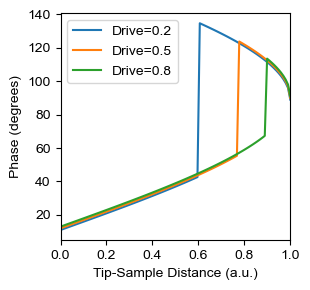

In [427]:
tp = phases.T[20]
x = np.linspace(0,1,len(tp))
plt.figure(figsize=[3.2,3])
plt.plot(x, phases.T[20]-1, label='Drive=0.2')
plt.plot(x, phases.T[50], label='Drive=0.5')
plt.plot(x, phases.T[80]+1, label='Drive=0.8')
plt.legend()
plt.xlim(0, 1.)
plt.xlabel('Tip-Sample Distance (a.u.)')
plt.ylabel('Phase (degrees)')
plt.tight_layout()

# plt.savefig('output/Three phase examples.png', dpi=400, bbox_inches='tight', pad_inches=0.1)


In [329]:
from numba import njit, prange
import numpy as np

@njit
def reward_grid(h1, h2, ph1, ph2, setpoint=1, offset=0):
    """
    Compute the reward based on height and phase differences.
    """
    # Reverse h2 manually
    h2_reversed = h2[:, ::-1]
    diff = np.abs(h1 - h2_reversed)
    height_trace_factor = np.sum(np.abs(diff / (h1-np.min(h1)+1))) * 1e2

    # Compute phase adjustments
    ph1_masked = np.where(ph1 - offset > 90, 90, ph1)
    ph2_masked = np.where(ph2 - offset > 90, 90, ph2)

    m1 = np.sum(90 + offset - ph1_masked)
    m2 = np.sum(90 + offset - ph2_masked)

    phase_below_factor = max(np.e, m1 * m2)

    phase_factor2 = np.mean(np.abs(ph1-120)) + np.e

    # Compute final reward
    return -np.log(phase_factor2 * np.abs(height_trace_factor * np.log(phase_below_factor)))


@njit(parallel=True)
def measure_grid(img, kernel, drive, setpoint, i_gain=1e0, reward=True, trace=False):
    """
    Simulate forward and backward scans and compute rewards.
    """
    N1 = len(drive)
    N2 = len(setpoint)
    rewards = np.zeros((N1, N2))

    for i in prange(N1):  # Parallel outer loop
        for j in range(N2):
            # Replace `scan()` with your implementation
            z1, ph1, z2, ph2 = scan(img, kernel, drive[i], setpoint[j], i_gain, phase=True, retrace=True, noise=True)
            rewards[i, j] = reward_grid(z1, z2, ph1, ph2)

    return rewards





## Benchmarking the reward on a dense grid

In [ ]:
# Uncomment this cell if you want to run the benchmarking on a dense grid

# # Example use
# x1 = np.linspace(0.01, 1, num=100)
# x2 = np.linspace(0.01, 1, num=100)

# # Ensure `img` and `kernel_1` are appropriately defined
# rewards = measure_grid(img, kernel_1, drive=x1, setpoint=x2)

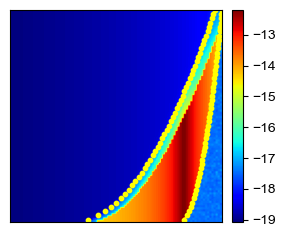

In [392]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=[3,3])
im = ax.imshow(rewards, extent=[0,1,0,1], origin='lower', cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Add the colorbar
cbar = fig.colorbar(im, cax=cax)

drive = np.linspace(0.01, 1, 50)

setpoint = (np.sqrt(drive))/5+0.8
setpoint2 = (np.sqrt(drive)/1.5 + 0.3)

ax.scatter(setpoint, drive, c='yellow', s=10)
ax.scatter(setpoint2, drive, c='yellow', s=10)

# ax.set_xlim(0,1)
# ax.set_ylim(0,1)
# ax.set_xlabel('Setpoint (a.u.)')
# ax.set_ylabel('Drive Amplitude (a.u.)')
ax.set_xticks([])
ax.set_yticks([])
# plt.savefig('output/rewards ground truth no labels.png', dpi=400, bbox_inches='tight', pad_inches=0.1)

In [335]:
# np.savetxt('rewards_test2.txt', rewards)

# Predicted rewards by the BO 

## 2D reward function

In [64]:
@njit
def reward_grid(h1, h2, ph1, ph2, setpoint=1, offset=0):
    """
    Compute the reward based on height and phase differences.
    """
    # Reverse h2 manually
    h2_reversed = h2[:, ::-1]
    diff = np.abs(h1 - h2_reversed)
    height_trace_factor = np.sum(np.abs(diff / (h1-np.min(h1)+1))) * 1e2

    # Compute phase adjustments
    ph1_masked = np.where(ph1 - offset > 90, 90, ph1)
    ph2_masked = np.where(ph2 - offset > 90, 90, ph2)

    m1 = np.sum(90 + offset - ph1_masked)
    m2 = np.sum(90 + offset - ph2_masked)

    phase_below_factor = max(np.e, m1 * m2)

    phase_factor2 = np.mean(np.abs(ph1-120)) + np.e

    # Compute final reward
    return -np.log(phase_factor2 * np.abs(height_trace_factor * np.log(phase_below_factor)))

## 2D measure function

In [337]:
# First of all, we need to define the behaviors of probes at too-large setpoint

# 1. it will be at a much higher height than the sample surface (long-range interaction)
# 2. it will be dominated by the random noise too
# 3. this part takes effect in the "Measure function"

def measure_with_noise(self, drive, setpoint, i_gain=1e0, repeat=1, reward=True, trace=False):

    # We need to simulate the fwd and bkd scans with the scanning parameters
    i_gain = 1e-2 if i_gain is None else i_gain
    # small enough setpoint case
    z1, ph1, z2, ph2 = scan(image=self.param['image'], kernel=self.param['kernel'], drive=drive,
                            setpoint=setpoint, I=i_gain, phase=True, retrace=True, noise=True)

    traces = []
    out = reward_grid(z1, z2, ph1, ph2, offset=0)

    if trace:
        traces.append([z1, z2, ph1, ph2])
        return out, traces
    else:
        return out

## Seeding function

In [338]:
def generate_seed(self, num=10, repeat=1):

    np.random.seed(35)
    X = self.param['X_array']

    idx = np.random.randint(0, len(X), num)

    X_measured = X[idx]
    X_exp_measured = self.param['X_exp'][idx]

    y_measured = np.zeros(len(idx))

    mask = np.ones(len(idx))

    indices_measured = idx
    indices_unmeasured = np.delete(np.arange(len(X)), idx, 0)

    self.update_param('num_seed', num)
    self.update_param('idx', idx)
    self.update_param('indices_unmeasured_seed', indices_unmeasured)
    self.update_param('indices_measured_seed', indices_measured)

    for i in range(num):
        if len(X_measured[i]) == 2:
            drive, setpoint = X_measured[i]
            i_gain = None
        else:
            drive, setpoint, i_gain = X_measured[i]

        y_measured[i], traces = self.measure_with_noise(drive=drive, setpoint=setpoint, i_gain=i_gain, repeat=repeat, trace=True)

        plot_seed(traces, i)

        self.update_param(key='index', value=(i+1) * repeat)

    plt.figure(figsize=[4,3])
    plt.scatter(X_exp_measured[:, 1], X_exp_measured[:, 0], c=y_measured, s=160, marker='s')
    plt.xlabel('Setpoint')
    plt.ylabel('Drive Amplitude')
    plt.tight_layout()

    X_unmeasured = np.delete(X, idx, axis=0)
    X_exp_unmeasured = np.delete(self.param['X_exp'], idx, axis=0)

    y_measured = np.asarray(y_measured, dtype=np.float32)

    self.update_param('X_measured_array_seed', X_measured)

    self.update_param('X_exp_measured', X_exp_measured)
    self.update_param('X_exp_unmeasured', X_exp_unmeasured)

    self.update_param('X_exp_measured_seed', X_exp_measured)
    self.update_param('X_exp_unmeasured_seed', X_exp_unmeasured)

    self.update_param('X_unmeasured_array_seed', X_unmeasured)
    self.update_param('y_measured_array_seed', y_measured)

    self.update_param('X_measured_tensor_seed', torch.from_numpy(X_measured))
    self.update_param('X_unmeasured_tensor_seed', torch.from_numpy(X_unmeasured))
    self.update_param('y_measured_tensor_seed', torch.from_numpy(y_measured))

def plot_seed(traces, i):

    clear_output(wait=True)
    fig, ax = plt.subplots(1, 2, figsize=(7, 3), dpi=200)

    h1, h2, ph1, ph2 = traces[0]

    ax[0].imshow(h1)
    ax[1].imshow(ph1)
    ax[0].set_title("Traces at sample={}".format(i+1))
    # ax[0].plot(h1)
    # ax[0].plot(h2)
    # ax[0].set_xlabel('Pixels')
    # ax[0].set_ylabel('Height (nm)')
    # ax[0].set_title("Traces at sample={}".format(i+1))
    # ax[1].plot(ph1)
    # ax[1].plot(ph2)
    # ax[1].axhline(90, linestyle='--', color='r')
    # ax[1].set_xlabel('Pixels')
    # ax[1].set_ylabel('Phase')
    # ax[1].set_title("Phases")
    # plt.tight_layout()
    plt.show()

## BO step function

In [340]:
def step(self, acquisition='EI', beta=4):

    gp_model = SingleTaskGP(self.param['X_measured_tensor'], torch.unsqueeze(self.param['y_measured_tensor'], dim=-1))

    # Fit GP model
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)

    fit_gpytorch_mll(mll)

    # Predict on unmeasured data
    gp_model.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        posterior = gp_model(self.param['X_unmeasured_tensor'])
        # For visualization or further processing, you can obtain mean and variance
        y_pred = posterior.mean
        y_sampled = posterior.variance.sqrt()

    # Compute acquisition function (Expected Improvement here)

    if acquisition=='UCB':
        UCB = UpperConfidenceBound(model=gp_model, beta=beta)
        acq_values = UCB(self.param['X_unmeasured_tensor'].unsqueeze(-2))
    elif acquisition=='EI':
        # EI = ExpectedImprovement(model=gp_model, best_f=y_measured.max(), maximize=True)
        EI = LogExpectedImprovement(model=gp_model, best_f=self.param['y_measured_tensor'].max(), maximize=True)
        acq_values = EI(self.param['X_unmeasured_tensor'].unsqueeze(-2))
    else:
        return 0

    self.update_param('acq_tensor', acq_values)
    self.update_param('y_pred_tensor', y_pred)
    self.update_param('y_sampled_tensor', y_sampled)

    self.update_param('acq_array', acq_values.detach().numpy())
    self.update_param('y_pred_array', y_pred.detach().numpy())
    self.update_param('y_sampled_array', y_sampled.detach().numpy())
    
# Active learning

def run_BO_loss(self, mask=None, fresh=True, num_steps=30, repeat=1,
           show=True, acquisition='EI', beta=4, save=None):

    import warnings

    warnings.filterwarnings('ignore')

    # waves = np.zeros([num_steps, repeat, 8, 256])

    if fresh:
        self.update_param('X_measured_array', self.param['X_measured_array_seed'])
        self.update_param('X_unmeasured_array', self.param['X_unmeasured_array_seed'])
        self.update_param('y_measured_array', self.param['y_measured_array_seed'])

        self.update_param('X_exp_measured', self.param['X_exp_measured_seed'])
        self.update_param('X_exp_unmeasured', self.param['X_exp_unmeasured_seed'])

        self.update_param('X_measured_tensor', self.param['X_measured_tensor_seed'])
        self.update_param('X_unmeasured_tensor', self.param['X_unmeasured_tensor_seed'])
        self.update_param('y_measured_tensor', self.param['y_measured_tensor_seed'])

        self.update_param('indices_measured', self.param['indices_measured_seed'])
        self.update_param('indices_unmeasured', self.param['indices_unmeasured_seed'])

    y_measured = self.param['y_measured_tensor']
    X_measured = self.param['X_measured_tensor']
    X_unmeasured = self.param['X_unmeasured_tensor']

    X_exp_measured = self.param['X_exp_measured']
    X_exp_unmeasured = self.param['X_exp_unmeasured']

    loss = []

    rewards_all = []

    scan_opt = []

    param_opt = []

    for e in range(num_steps):

        self.step(acquisition=acquisition, beta=beta)

        if mask is None:
            acq_masked = self.param['acq_array']
        else:
            acq = self.param['acq_array']
            acq_masked = (acq-acq.min()) * mask.flatten()[self.param['indices_unmeasured']]

        self.update_param('acq_masked', acq_masked)

        next_idx = acq_masked.argmax()
        next_point_exp = X_exp_unmeasured[next_idx]
        next_point = X_unmeasured[next_idx]

        if len(next_point_exp) == 2:
            v_ac, setpoint = next_point_exp
            i_gain = None
        else:
            v_ac, setpoint, i_gain = next_point_exp
        if not e:
            next_measure, traces = self.measure_with_noise(drive=v_ac, setpoint=setpoint, i_gain=i_gain, repeat=repeat, trace=True)
        else:
            next_measure, traces = self.measure_with_noise(drive=v_ac, setpoint=setpoint, i_gain=i_gain, repeat=repeat, trace=True)
        # waves[e] = w

        if show is True:
            self.plot_bo(title='Prediction at {}'.format(e+1))

        next_point = torch.tensor(next_point, dtype=torch.float32)
        next_measure = torch.tensor([next_measure], dtype=torch.float32)

        y_measured = torch.cat((y_measured, next_measure), axis=0)

        X_measured = torch.cat((X_measured, next_point.unsqueeze(-2)), axis=0)

        X_unmeasured = torch.tensor(np.delete(X_unmeasured, next_idx, axis=0), dtype=torch.float32)

        X_exp_measured =  np.concatenate((self.param['X_exp_measured'], [next_point_exp]), axis=0)
        X_exp_unmeasured = np.delete(X_exp_unmeasured, next_idx, axis=0)
        self.update_param('X_exp_measured', X_exp_measured)
        self.update_param('X_exp_unmeasured', X_exp_unmeasured)

        self.update_param('X_measured_tensor', X_measured)
        self.update_param('X_unmeasured_tensor', X_unmeasured)
        self.update_param('y_measured_tensor', y_measured)

        self.update_param('X_measured_array', X_measured.detach().numpy())
        self.update_param('X_unmeasured_array', X_unmeasured.detach().numpy())
        self.update_param('y_measured_array', y_measured.detach().numpy())

        self.update_param('indices_measured', np.concatenate((self.param['indices_measured'], [next_idx])))
        self.update_param('indices_unmeasured', np.delete(self.param['indices_unmeasured'], next_idx))

        y_pred = self.train_BO_loss(acquisition=acquisition, beta=beta)

        index_min = y_pred.argmax()

        v_ac_op = self.param['X_exp'][index_min][0]
        setpoint_op = self.param['X_exp'][index_min][1]

        img_op, phase_op, *_ = scan(image=self.param['image'], kernel=self.param['kernel'], drive=v_ac_op, setpoint=setpoint_op, phase=True)

        scan_opt.append([img_op, phase_op])
        param_opt.append([v_ac_op, setpoint_op])
        rewards_all.append(y_pred)

        loss.append(np.abs(img_op-self.param['image']).mean())

    self.update_param('scan_opt', scan_opt)
    self.update_param('param_opt', param_opt)
    self.update_param('loss', loss)
    self.update_param('rewards_all', np.array(rewards_all))

def plot_bo(self, title=''):

    X_measured = self.param['X_exp_measured']
    X_unmeasured = self.param['X_exp_unmeasured']

    y_measured = self.param['y_measured_array']
    acq = self.param['acq_masked']
    y_pred = self.param['y_pred_array']
    y_sampled = self.param['y_sampled_array']
    num_seed = self.param['num_seed']

    clear_output(wait=True)
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    im1 = ax[0].scatter(X_unmeasured[:, 1], X_unmeasured[:, 0], c=y_pred, s=40, cmap='jet')
    ax[0].set_title("{}".format(title))

    im2 = ax[1].scatter(X_unmeasured[:, 1], X_unmeasured[:, 0], c=acq, s=40, cmap='jet')
    ax[1].set_title("Acquisition")

    ax[2].scatter(X_unmeasured[:, 1], X_unmeasured[:, 0], c=y_pred, cmap='gray')
    ax[2].scatter(X_measured[:num_seed,1], X_measured[:num_seed,0], c = 'k')

    im3 = ax[2].scatter(X_measured[num_seed:, 1], X_measured[num_seed:, 0], marker='o', s=50,
                        c = np.arange(len(X_measured)-num_seed), cmap = 'rainbow')
    ax[2].set_title("BO trajectory")

    for axis in ax:
        axis.set_xlabel('Setpoint')
        axis.set_ylabel('Drive Amplitude')

    plt.colorbar(im1, ax=ax[0])
    plt.colorbar(im2, ax=ax[1])
    plt.colorbar(im3, ax=ax[2])
    plt.tight_layout()
    plt.show()
    
# Visualize the training result
def train_BO_loss(self, acquisition='EI', beta=4):

    X = self.param['X_tensor']
    X_measured = self.param['X_measured_tensor']
    y_measured = self.param['y_measured_tensor']

    gp_model = SingleTaskGP(X_measured, torch.unsqueeze(y_measured, dim=-1))
    # Fit GP model
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)

    fit_gpytorch_mll(mll)

    # Predict on unmeasured data
    gp_model.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        posterior = gp_model(X)
        # For visualization or further processing, you can obtain mean and variance
        y_pred = posterior.mean
        y_sampled = posterior.variance.sqrt()

    if acquisition=='UCB':
        UCB = UpperConfidenceBound(model=gp_model, beta=beta)
        acq_values = UCB(X.unsqueeze(-2))
    elif acquisition=='EI':
        EI = ExpectedImprovement(model=gp_model, best_f=y_measured.max(), maximize=True)
        acq_values = EI(X.unsqueeze(-2))
    else:
        return 0

    return y_pred.detach().numpy()

    # self.update_param('acq_tensor', acq_values)
    # self.update_param('y_pred_tensor', y_pred)
    # self.update_param('y_sampled_tensor', y_sampled)

    # self.update_param('acq_array', acq_values.detach().numpy())
    # self.update_param('y_pred_array', y_pred.detach().numpy())
    # self.update_param('y_sampled_array', y_sampled.detach().numpy())


## Attach all the BO functions

In [341]:
exp = Experiment()

# exp.add_func(reward)
exp.add_func(generate_seed)
exp.add_func(measure_with_noise)

exp.add_func(step)
exp.add_func(plot_bo)
exp.add_func(run_BO_loss)
exp.add_func(train_BO_loss)
# exp.add_func(acq_mask)

## Set up the Experiment

In [342]:
exp.update_param('image', img)
exp.update_param('kernel', kernel_1)

# v_ac in V
x1_min = 0.01
x1_max = 1
num1 = 100

# setpoint
x2_min = 0.01
x2_max = 1
num2 = 100

# Make the grid for exploration

# exp.update_param('factor', factor)
exp.update_param('offset', 0)
exp.update_param('num1', num1)
exp.update_param('num2', num2)
exp.update_param('index', 0)

x1 = np.linspace(x1_min, x1_max, num=num1)
x2 = np.linspace(x2_min, x2_max, num=num2)

x1_norm = np.linspace(0, 1, num=num1)
x2_norm = np.linspace(0, 1, num=num2)

x_exp = []

for i in range(len(x1)):
    for j in range(len(x2)):
        x_exp.append([x1[i], x2[j]])

exp.update_param('X_exp', np.asarray(x_exp, dtype=np.float32))

x = []

for i in range(len(x1_norm)):
    for j in range(len(x2_norm)):
        x.append([x1_norm[i], x2_norm[j]])

x = np.asarray(x, dtype=np.float32)
X = torch.from_numpy(x)
# X = np.copy(x)
# exp.update_param('X', x)
exp.update_param('X_array', x)
exp.update_param('X_tensor', X)

## Generate seeds

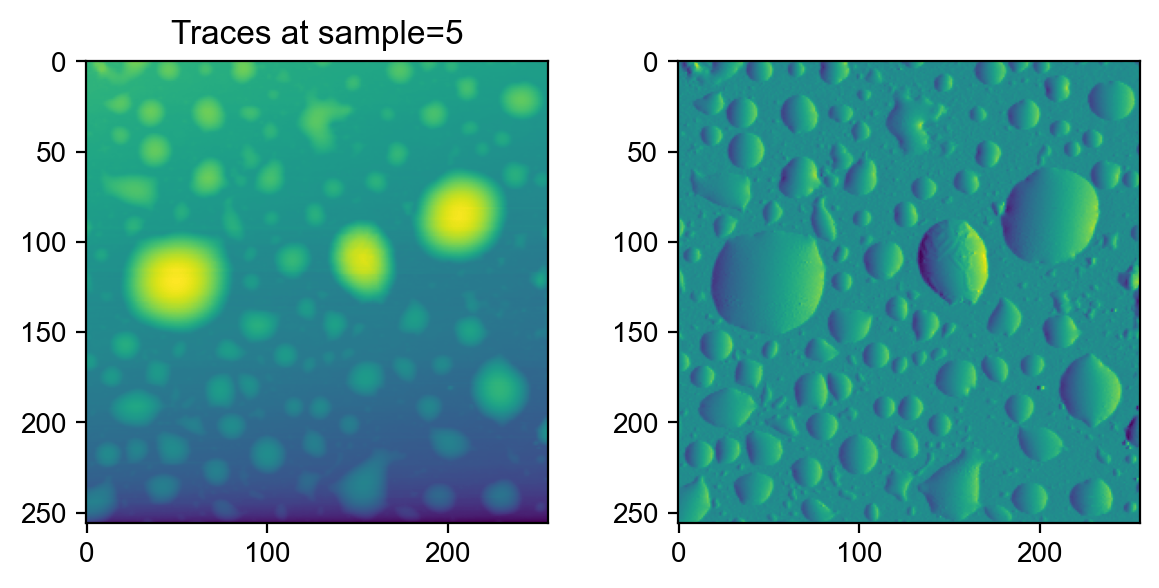

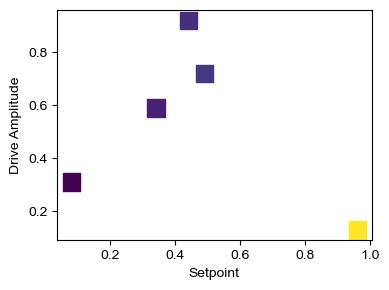

In [343]:
exp.generate_seed(num=5, repeat=1)

## BO training

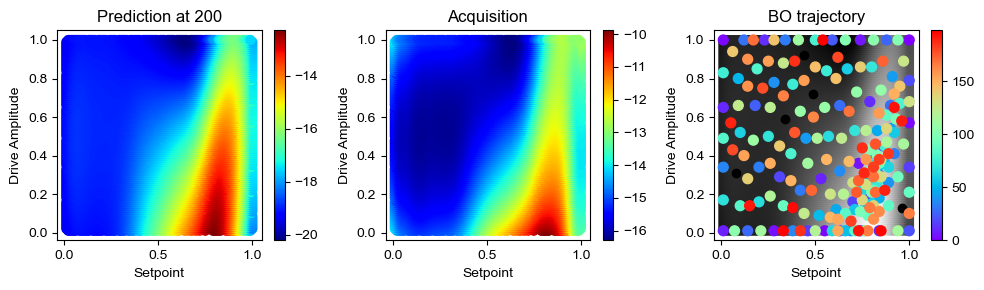

In [344]:
exp.run_BO_loss(mask=None, num_steps=200, repeat=1, show=True, fresh=True,
           acquisition='UCB', beta=100)

## Benchmarking the BO algorithms

In [345]:
loss = np.zeros(200)

for i in range(len(loss)):
    # loss[i] = np.mean(np.abs(exp.param['rewards_all'][i].reshape([100,100])-rewards)/(rewards - np.min(rewards)+1))
    loss[i] = np.mean(np.abs(exp.param['rewards_all'][i].reshape([100,100])-rewards)/(rewards - np.min(rewards) + 1))

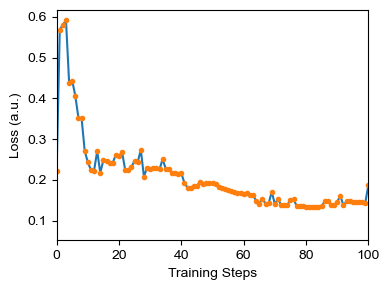

In [353]:
plt.figure(figsize=[4,3])
plt.plot(loss)
plt.plot(loss, '.')
plt.xlabel('Training Steps')
plt.ylabel('Loss (a.u.)')
plt.xlim(0, 100)
plt.tight_layout()
# plt.savefig('output/loss function 100.png', dpi=400, bbox_inches='tight', pad_inches=0.1)

In [347]:
index = np.where(np.abs(rewards - np.max(rewards)) < 0.1)
reward_pts = []

for i in range(len(index[0])):
    reward_pts.append([x1[index[0][i]], x2[index[1][i]]])

reward_pts = np.array(reward_pts)

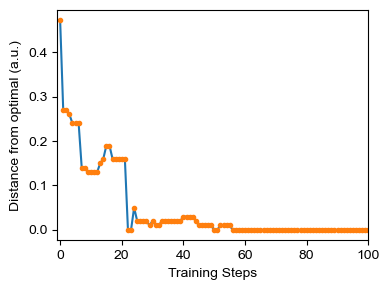

In [355]:
plt.figure(figsize=[4,3])
plt.plot(distance1)
plt.plot(distance1, '.')
plt.xlim(-1, 100)
plt.xlabel('Training Steps')
plt.ylabel('Distance from optimal (a.u.)')
plt.tight_layout()
# plt.savefig('output/loss distance function 100.png', dpi=400, bbox_inches='tight', pad_inches=0.1)

In [370]:
# import pickle
# with open('output/UCB_training.pkl', 'wb') as file:  # Use 'wb' mode for writing in binary
#     pickle.dump(exp.param, file)

### Visualize the training steps

In [364]:
plt.rcParams['animation.ffmpeg_path'] = r"C:\Program Files\ffmpeg\bin\ffmpeg.exe"
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec

In [365]:
exp.param.keys()

dict_keys(['image', 'kernel', 'offset', 'num1', 'num2', 'index', 'X_exp', 'X_array', 'X_tensor', 'num_seed', 'idx', 'indices_unmeasured_seed', 'indices_measured_seed', 'X_measured_array_seed', 'X_exp_measured', 'X_exp_unmeasured', 'X_exp_measured_seed', 'X_exp_unmeasured_seed', 'X_unmeasured_array_seed', 'y_measured_array_seed', 'X_measured_tensor_seed', 'X_unmeasured_tensor_seed', 'y_measured_tensor_seed', 'X_measured_array', 'X_unmeasured_array', 'y_measured_array', 'X_measured_tensor', 'X_unmeasured_tensor', 'y_measured_tensor', 'indices_measured', 'indices_unmeasured', 'acq_tensor', 'y_pred_tensor', 'y_sampled_tensor', 'acq_array', 'y_pred_array', 'y_sampled_array', 'acq_masked', 'scan_opt', 'param_opt', 'loss', 'rewards_all'])

In [371]:
# Visualize the training result
def train_BO(param, end=None, acquisition='EI', beta=4):

    X = param['X_tensor']
    if end is None:
        X_measured = param['X_measured_tensor']
        y_measured = param['y_measured_tensor']
    else:
        X_measured = param['X_measured_tensor'][:end]
        y_measured = param['y_measured_tensor'][:end]

    gp_model = SingleTaskGP(X_measured, torch.unsqueeze(y_measured, dim=-1))
    # Fit GP model
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)

    fit_gpytorch_mll(mll)

    # Predict on unmeasured data
    gp_model.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        posterior = gp_model(X)
        # For visualization or further processing, you can obtain mean and variance
        y_pred = posterior.mean
        y_sampled = posterior.variance.sqrt()

    if acquisition=='UCB':
        UCB = UpperConfidenceBound(model=gp_model, beta=beta)
        acq_values = UCB(X.unsqueeze(-2))
    elif acquisition=='EI':
        EI = ExpectedImprovement(model=gp_model, best_f=y_measured.max(), maximize=True)
        acq_values = EI(X.unsqueeze(-2))
    else:
        return 0

    return acq_values, y_pred, y_sampled
    
def plot_BO_steps(param, ground_truth, step, acquisition='EI', beta=4, fig=False):

    X_exp = param['X_exp']
    X_measured = param['X_measured_array']
    
    num_seed = 5
    end = num_seed + step

    acq, y_pred, y_sampled = train_BO(param, end=end, acquisition=acquisition, beta=beta)
    
    # Create a figure
    if fig == False:
        fig = plt.figure(figsize=(9, 9))

    # Create a GridSpec with 2 rows and 2 columns
    gs = gridspec.GridSpec(2, 2)

    ax1 = []

    for i in range(2):
        for j in range(2):
            ax = fig.add_subplot(gs[i, j])
            ax.set_aspect('equal')
            ax1.append(ax)

    im1 = ax1[0].scatter(X_exp[:, 1], X_exp[:, 0], c=y_pred, s=40, cmap='jet')
    ax1[0].set_title("Reward Step={}".format(step))
    im2 = ax1[2].scatter(X_exp[:, 1], X_exp[:, 0], c=acq.detach().numpy(), s=40, cmap='jet')
    ax1[2].set_title("Acquisition")

    ax1[3].scatter(X_exp[:, 1], X_exp[:, 0], c=y_pred, cmap='gray')
    ax1[3].scatter(X_measured[:num_seed,1], X_measured[:num_seed,0], c = 'k')
    im3 = ax1[3].scatter(X_measured[num_seed:end, 1], X_measured[num_seed:end, 0], 
                        marker='o', s=50,c = np.arange(step), cmap = 'rainbow')
    ax1[3].plot(X_measured[end-1, 1], X_measured[end-1, 0],  'rx', ms=8, mew=2)
    # ax1[2].plot(X_exp[index_min][1] * 1e2, X_exp[index_min][0] * conv, 'rx', ms=8, mew=2)

    ax1[3].set_title("BO trajectory")

    im4 = ax1[1].imshow(ground_truth, origin='lower', extent=[0,1,0,1],cmap='jet')
    ax1[1].set_title("Ground Truth Rewards")

    divider1 = make_axes_locatable(ax1[0])
    divider2 = make_axes_locatable(ax1[1])
    divider3 = make_axes_locatable(ax1[2])
    divider4 = make_axes_locatable(ax1[3])
    
    cax1 = divider1.append_axes("right", size="5%", pad=0.1)
    cax2 = divider2.append_axes("right", size="5%", pad=0.1)
    cax3 = divider3.append_axes("right", size="5%", pad=0.1)
    cax4 = divider4.append_axes("right", size="5%", pad=0.1)
    
    # Add the colorbar
    cbar1 = fig.colorbar(im1, cax=cax1)
    cbar2 = fig.colorbar(im2, cax=cax3)
    cbar3 = fig.colorbar(im3, cax=cax4)
    cbar4 = fig.colorbar(im4, cax=cax2)
    
    for axis in ax1:
        axis.set_xlabel('Setpoint')
        axis.set_ylabel('Drive Amplitude')


    # plt.colorbar(im1, ax=ax1[0])
    # plt.colorbar(im2, ax=ax1[2])
    # plt.colorbar(im3, ax=ax1[3])
    # plt.colorbar(im4, ax=ax1[1])

    plt.tight_layout()
#     plt.show()

def write_animation(name, param, ground_truth, acquisition='EI', beta=4, frames=100):
    fig = plt.figure(figsize=(9, 9))

    def update(step):
        plt.clf()
        plot_BO_steps(param, ground_truth, step=step, acquisition=acquisition, beta=beta, fig=fig)

    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=frames, repeat=False)

    # Save the animation
    ani.save('{}.mp4'.format(name), writer='ffmpeg', dpi=200, bitrate=1e5, fps=0.5)

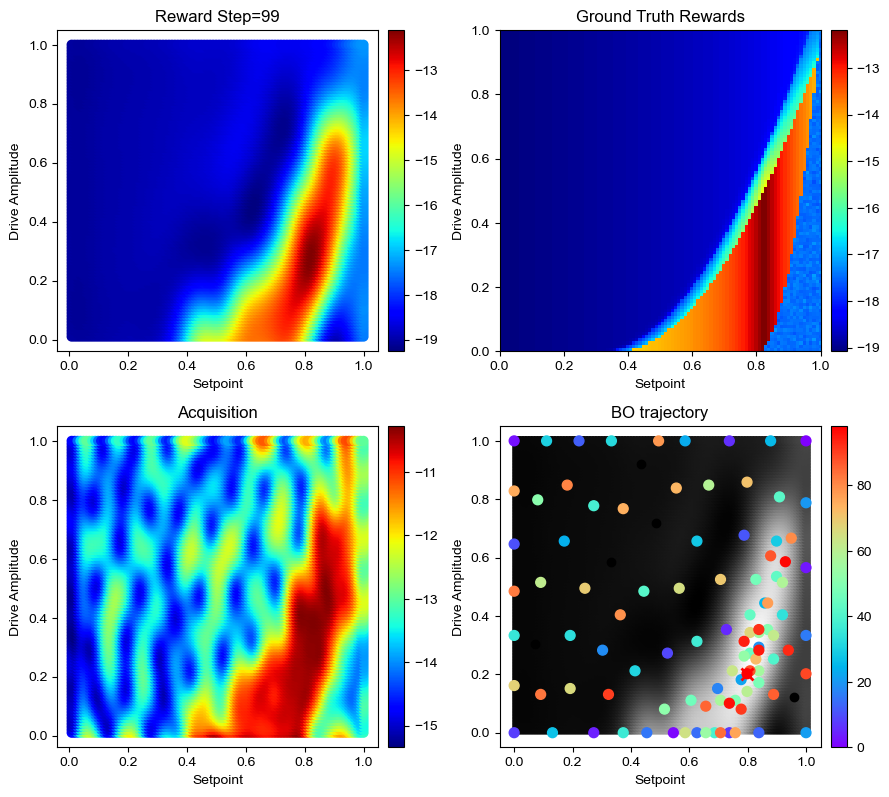

In [372]:
write_animation("output/UCB training", param=exp.param, ground_truth=rewards, acquisition='UCB', beta=100)

### Let's try EI acquisition function now!

In [373]:
exp = Experiment()

# exp.add_func(reward)
exp.add_func(generate_seed)
exp.add_func(measure_with_noise)

exp.add_func(step)
exp.add_func(plot_bo)
exp.add_func(run_BO_loss)
exp.add_func(train_BO_loss)
# exp.add_func(acq_mask)

exp.update_param('image', img)
exp.update_param('kernel', kernel_1)

# v_ac in V
x1_min = 0.01
x1_max = 1
num1 = 100

# setpoint
x2_min = 0.01
x2_max = 1
num2 = 100

# Make the grid for exploration

# exp.update_param('factor', factor)
exp.update_param('offset', 0)
exp.update_param('num1', num1)
exp.update_param('num2', num2)
exp.update_param('index', 0)

x1 = np.linspace(x1_min, x1_max, num=num1)
x2 = np.linspace(x2_min, x2_max, num=num2)

x1_norm = np.linspace(0, 1, num=num1)
x2_norm = np.linspace(0, 1, num=num2)

x_exp = []

for i in range(len(x1)):
    for j in range(len(x2)):
        x_exp.append([x1[i], x2[j]])

exp.update_param('X_exp', np.asarray(x_exp, dtype=np.float32))

x = []

for i in range(len(x1_norm)):
    for j in range(len(x2_norm)):
        x.append([x1_norm[i], x2_norm[j]])

x = np.asarray(x, dtype=np.float32)
X = torch.from_numpy(x)
# X = np.copy(x)
# exp.update_param('X', x)
exp.update_param('X_array', x)
exp.update_param('X_tensor', X)

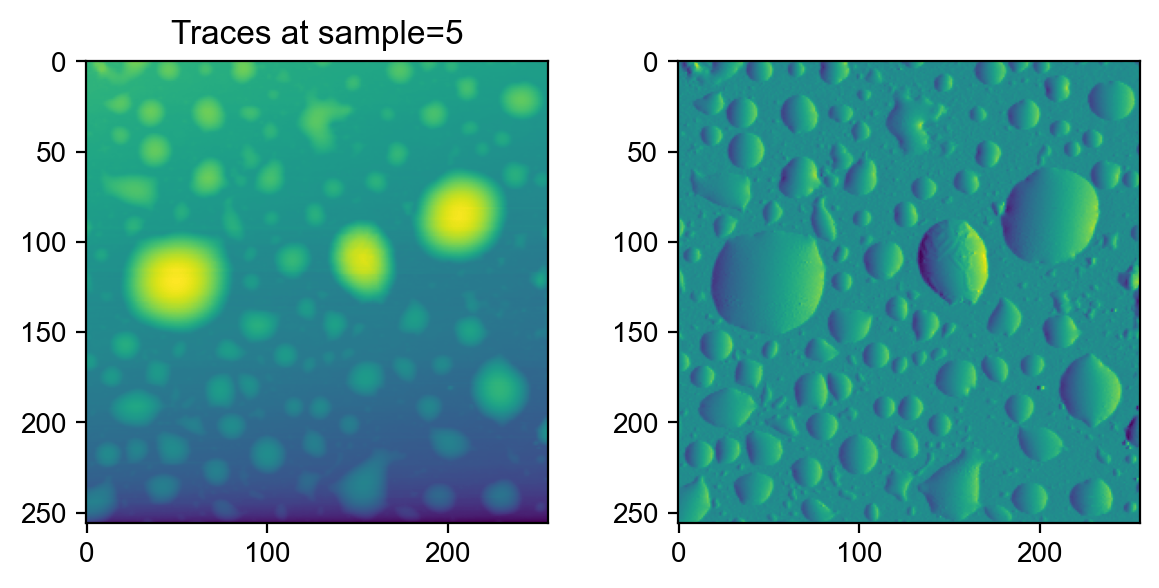

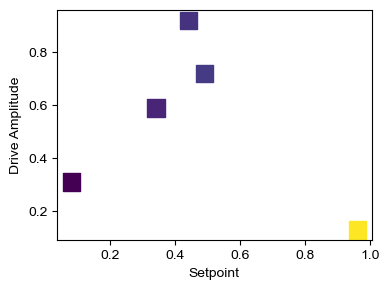

In [374]:
exp.generate_seed(num=5, repeat=1)

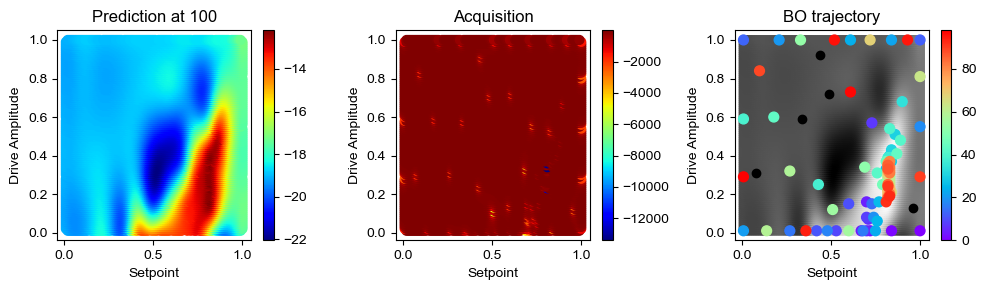

In [375]:
exp.run_BO_loss(mask=None, num_steps=100, repeat=1, show=True, fresh=True,
           acquisition='EI', beta=100)

In [376]:
# import pickle
# with open('output/EI_training.pkl', 'wb') as file:  # Use 'wb' mode for writing in binary
#     pickle.dump(exp.param, file)

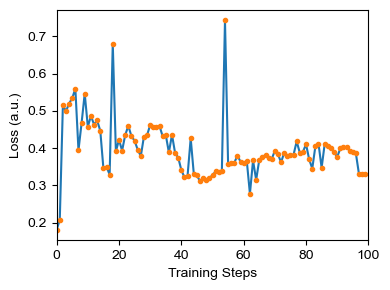

In [377]:
loss = np.zeros(100)

for i in range(len(loss)):
    # loss[i] = np.mean(np.abs(exp.param['rewards_all'][i].reshape([100,100])-rewards)/(rewards - np.min(rewards)+1))
    loss[i] = np.mean(np.abs(exp.param['rewards_all'][i].reshape([100,100])-rewards)/(rewards - np.min(rewards) + 1))

plt.figure(figsize=[4,3])
plt.plot(loss)
plt.plot(loss, '.')
plt.xlabel('Training Steps')
plt.ylabel('Loss (a.u.)')
plt.xlim(0, 100)
plt.tight_layout()
plt.savefig('output/loss function 100 EI.png', dpi=400, bbox_inches='tight', pad_inches=0.1)

In [378]:
index = np.where(np.abs(rewards - np.max(rewards)) < 0.1)
reward_pts = []

for i in range(len(index[0])):
    reward_pts.append([x1[index[0][i]], x2[index[1][i]]])

reward_pts = np.array(reward_pts)

tp = np.array(exp.param['param_opt'])

distance1 = np.zeros(len(tp))

for i in range(len(tp)):
    # Compute squared distances between A and all points in B
    distances_squared = np.sum((reward_pts - tp[i]) ** 2, axis=1)
    
    # Find the minimum distance
    distance1[i] = np.sqrt(np.min(distances_squared))

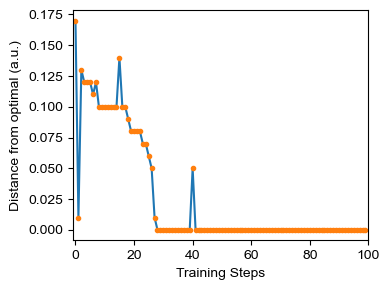

In [379]:
plt.figure(figsize=[4,3])
plt.plot(distance1)
plt.plot(distance1, '.')
plt.xlim(-1, 100)
plt.xlabel('Training Steps')
plt.ylabel('Distance from optimal (a.u.)')
plt.tight_layout()
plt.savefig('output/loss distance function 100 EI.png', dpi=400, bbox_inches='tight', pad_inches=0.1)

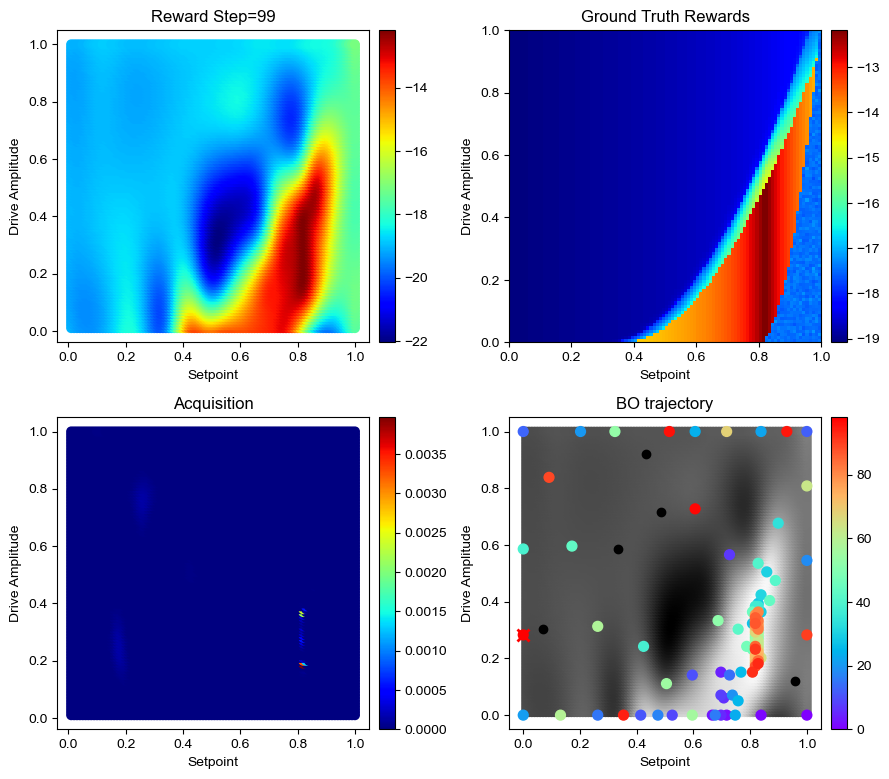

In [380]:
write_animation("output/EI training", param=exp.param, ground_truth=rewards, acquisition='EI', beta=100)

In [393]:
import pickle
with open('output/UCB_training.pkl', 'rb') as file:  # Use 'wb' mode for writing in binary
    param_ucb = pickle.load(file)

with open('output/EI_training.pkl', 'rb') as file:  # Use 'wb' mode for writing in binary
    param_ei = pickle.load(file)

In [395]:
loss1 = np.zeros(100)
loss2 = np.zeros(100)

for i in range(len(loss)):
    # loss[i] = np.mean(np.abs(exp.param['rewards_all'][i].reshape([100,100])-rewards)/(rewards - np.min(rewards)+1))
    loss1[i] = np.mean(np.abs(param_ucb['rewards_all'][i].reshape([100,100])-rewards)/(rewards - np.min(rewards) + 1))
    loss2[i] = np.mean(np.abs(param_ei['rewards_all'][i].reshape([100,100])-rewards)/(rewards - np.min(rewards) + 1))
    

In [396]:
index = np.where(np.abs(rewards - np.max(rewards)) < 0.1)
reward_pts = []

for i in range(len(index[0])):
    reward_pts.append([x1[index[0][i]], x2[index[1][i]]])

reward_pts = np.array(reward_pts)

In [398]:
tp1 = np.array(param_ucb['param_opt'])

distance1 = np.zeros(len(tp1))

tp2 = np.array(param_ei['param_opt'])

distance2 = np.zeros(len(tp2))

for i in range(100):
    # Compute squared distances between A and all points in B
    distances_squared = np.sum((reward_pts - tp1[i]) ** 2, axis=1)
    
    # Find the minimum distance
    distance1[i] = np.sqrt(np.min(distances_squared))

    distances_squared = np.sum((reward_pts - tp2[i]) ** 2, axis=1)
    
    # Find the minimum distance
    distance2[i] = np.sqrt(np.min(distances_squared))

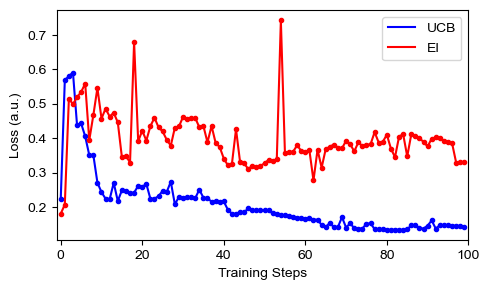

In [408]:
plt.figure(figsize=[5,3])
plt.plot(loss1, c='b', label='UCB')
plt.plot(loss1, '.', c='b')

plt.plot(loss2, c='r', label='EI')
plt.plot(loss2, '.', c='r')

plt.xlabel('Training Steps')
plt.ylabel('Loss (a.u.)')
plt.legend()
plt.xlim(-1, 100)
plt.tight_layout()
plt.savefig('output/loss function 100.png', dpi=400, bbox_inches='tight', pad_inches=0.1)

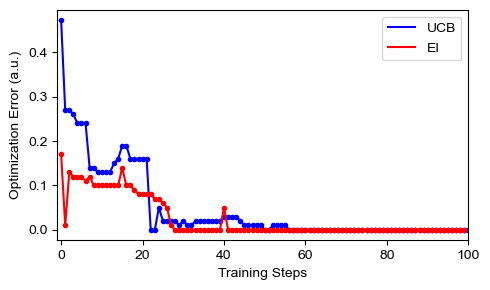

In [428]:
plt.figure(figsize=[5,3])
plt.plot(distance1, c='b', label='UCB')
plt.plot(distance1, '.', c='b')

plt.plot(distance2, c='r', label='EI')
plt.plot(distance2, '.', c='r')

plt.xlabel('Training Steps')
plt.ylabel('Optimization Error (a.u.)')
plt.legend()
plt.xlim(-1, 100)
plt.tight_layout()
plt.savefig('output/error function 100.png', dpi=400, bbox_inches='tight', pad_inches=0.1)